<a href="https://colab.research.google.com/github/AnishRane-cox/Cancer-Detection/blob/First-Model/Starter_code_Assignment_CNN_Skin_Cancer%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [2]:

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
!pwd

/content


In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123
num_classes = 9
epochs = 20

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='training',
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed = seed
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='validation',
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed = seed
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
print(f"Number of Tranning samples: {len(train_ds.file_paths)}")
print(f"Number of validation samples: {len(val_ds.file_paths)}")

Number of Tranning samples: 1792
Number of validation samples: 447


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

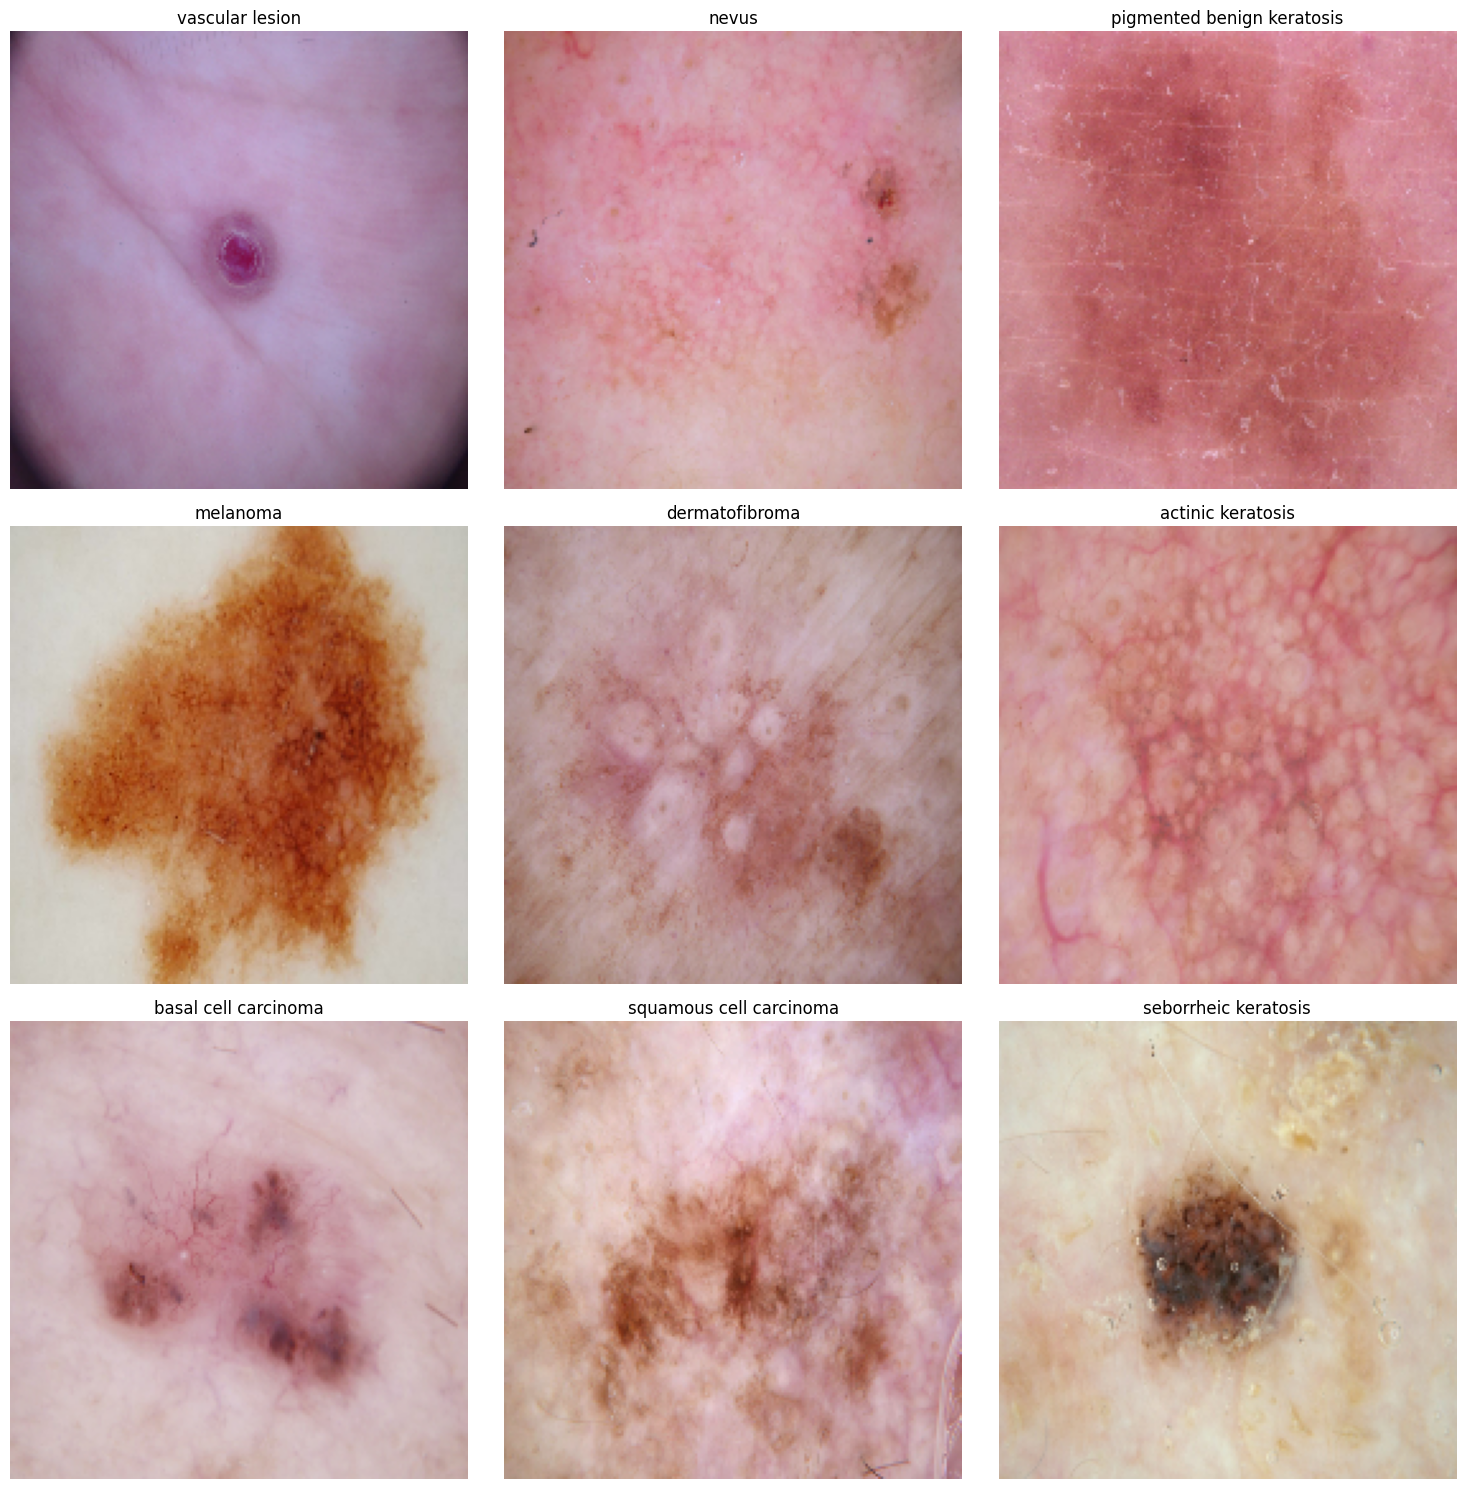

In [12]:
import matplotlib.pyplot as plt

def visualize_class(dataset, class_names, num_classes = 9):
  plt.figure(figsize = (15,15))

  # Dictionary to store one example per class
  class_examples = {}

  # Iterate through the dataset to collect one example per class
  for images, labels in train_ds:
    for image, label in zip(images,labels):
      class_name = class_names[label.numpy()]
      if class_name not in class_examples:
        class_examples[class_name] = image
      if len(class_examples) == num_classes:
        break
    if len(class_examples) == num_classes:
      break

  # Plotting the examples
  for idx, (class_name, image) in enumerate(class_examples.items(),1):
    plt.subplot(3,3,idx)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
  plt.tight_layout()
  plt.show()

# Using Tranning Dataset
visualize_class(
    train_ds,
    class_names,
    num_classes=9
)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
num_classes = 9  # Change based on your dataset

# Apply one-hot encoding to the labels
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
'''model = models.Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])'''

"model = models.Sequential([\n        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),\n        layers.Conv2D(32, (3, 3), activation='relu'),\n        layers.MaxPooling2D((2, 2)),\n        layers.Conv2D(64, (3, 3), activation='relu'),\n        layers.MaxPooling2D((2, 2)),\n        layers.Conv2D(128, (3, 3), activation='relu'),\n        layers.MaxPooling2D((2, 2)),\n        layers.Flatten(),\n        layers.Dense(128, activation='relu'),\n        layers.Dense(num_classes, activation='softmax')\n    ])"

The error you're encountering is due to the use of the experimental module, which is no longer available in recent versions of TensorFlow/Keras.

In [16]:
model = models.Sequential([
    # Correct way to use the Rescaling layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values to [0, 1]
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Assuming 10 classes for classification
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 215168)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      27,541,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,636,041 (105.42 MB)

 Trainable params: 27,636,041 (105.42 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 215168)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      27,541,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,636,041 (105.42 MB)

 Trainable params: 27,636,041 (105.42 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [19]:
history = model.fit(train_ds,batch_size=batch_size,epochs=epochs,validation_data=val_ds,shuffle=True)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - accuracy: 0.2045 - loss: 2.7644 - val_accuracy: 0.4206 - val_loss: 1.7707
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3623 - loss: 1.7203 - val_accuracy: 0.4966 - val_loss: 1.5070
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4755 - loss: 1.5273 - val_accuracy: 0.4989 - val_loss: 1.4417
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4982 - loss: 1.3932 - val_accuracy: 0.5302 - val_loss: 1.4180
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5221 - loss: 1.3405 - val_accuracy: 0.5145 - val_loss: 1.4005
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5512 - loss: 1.2482 - val_accuracy: 0.5280 - val_loss: 1.4047
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5729 - loss: 1.2200 - val_accuracy: 0.5011 - val_loss: 1.4265
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5579 - loss: 1.2078 - val_accuracy: 0.5034 -

### Visualizing training results

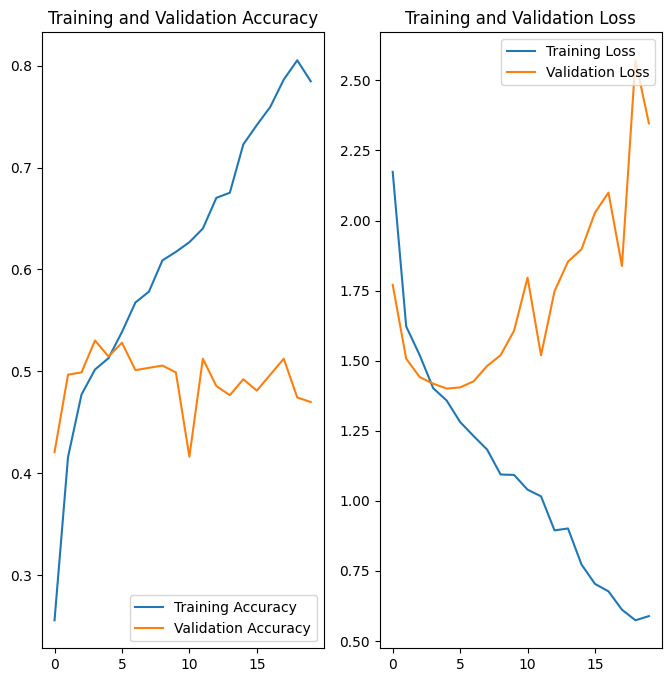

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The training accuracy continues to rise while the validation accuracy stagnates or even decreases.
The training loss decreases, but the validation loss increases towards the end, showing the model is overfitting the training data. It has learned patterns in the training data but fails to generalize to new, unseen data.

Conclusion: The model is overfitting due to memorizing the training data instead of learning generalizable features.

In [49]:
# Define the augmentation model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Flip images horizontally
    layers.RandomRotation(0.2),       # Increase random rotation
    layers.RandomZoom(0.2),           # Increase random zoom
    layers.RandomTranslation(0.2, 0.2),  # Increase random translation
    layers.RandomContrast(0.2),       # Add random contrast adjustment
])

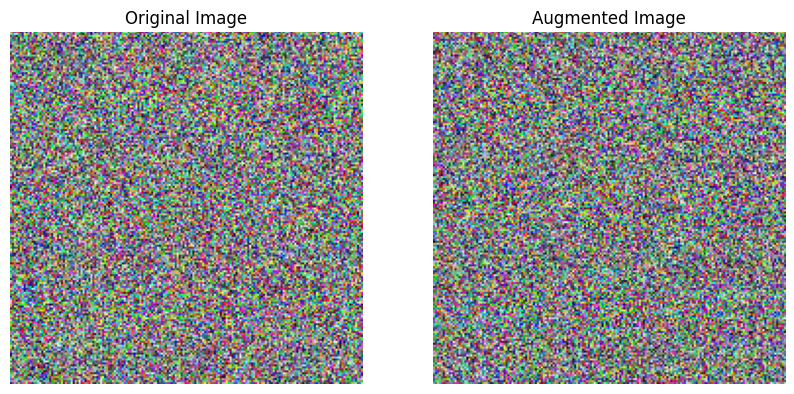

In [50]:
# Get a batch of images from the training dataset
for images, labels in train_ds.take(1):  # Take one batch
    sample_image = images[0]  # Choose the first image in the batch

# Apply the augmentation model to the sample image
augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))

# Denormalize the image to get it back to the range [0, 255] for display
sample_image = sample_image.numpy() * 255
augmented_image = augmented_image[0].numpy() * 255

# Plot the original and augmented images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image.astype("uint8"))  # Convert tensor to uint8 for display
plt.title("Original Image")
plt.axis('off')

# Augmented image
plt.subplot(1, 2, 2)
plt.imshow(augmented_image.astype("uint8"))  # Convert tensor to uint8 for display
plt.title("Augmented Image")
plt.axis('off')

plt.show()

In [51]:
model = tf.keras.Sequential([
    data_augmentation,  # Apply augmentation before training
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9-class classification
])

In [52]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
history2 = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.2115 - loss: 2.4115 - val_accuracy: 0.3199 - val_loss: 1.8603
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3455 - loss: 1.7928 - val_accuracy: 0.3669 - val_loss: 1.7123
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4105 - loss: 1.6281 - val_accuracy: 0.5190 - val_loss: 1.4702
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4619 - loss: 1.5263 - val_accuracy: 0.4989 - val_loss: 1.4910
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.4771 - loss: 1.5287 - val_accuracy: 0.5257 - val_loss: 1.3993
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4933 - loss: 1.3832 - val_accuracy: 0.4944 - val_loss: 1.4034
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.4994 - loss: 1.4170 - val_accuracy: 0.4944 - val_loss: 1.4381
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4974 - loss: 1.4246 - val_accuracy: 0.5056 - v

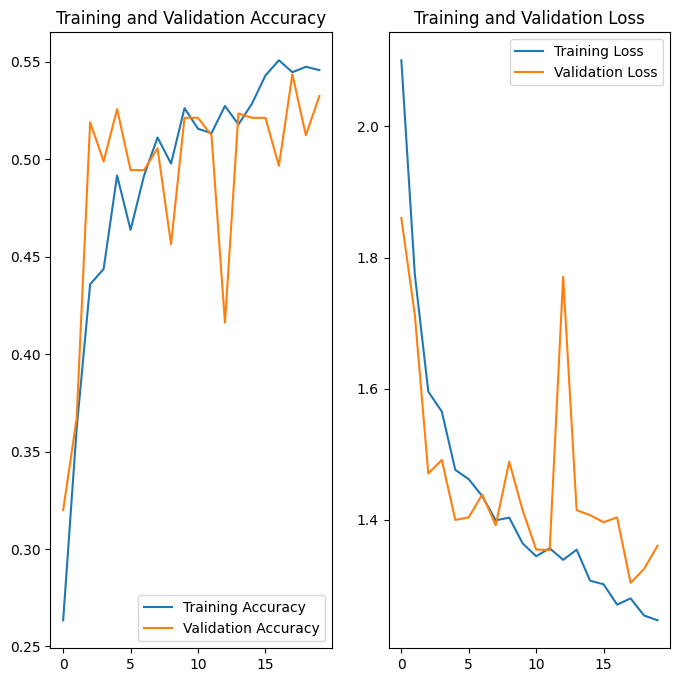

In [54]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Todo:
### Create the model, compile and train the model


In [62]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = tf.keras.Sequential([
    data_augmentation,  # Apply augmentation before training
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9-class classification
])



### Compiling the model

In [63]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [64]:
history3 = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.2019 - loss: 2.5578 - val_accuracy: 0.1924 - val_loss: 2.0615
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2072 - loss: 2.0182 - val_accuracy: 0.3468 - val_loss: 1.8614
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3425 - loss: 1.8290 - val_accuracy: 0.4161 - val_loss: 1.6594
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3671 - loss: 1.7060 - val_accuracy: 0.4810 - val_loss: 1.5435
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4283 - loss: 1.6016 - val_accuracy: 0.5011 - val_loss: 1.4954
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.4728 - loss: 1.5007 - val_accuracy: 0.4832 - val_loss: 1.4827
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4448 - loss: 1.5443 - val_accuracy: 0.5123 - val_loss: 1.4487
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4498 - loss: 1.4743 - val_accuracy: 0.5123 - v

### Visualizing the results

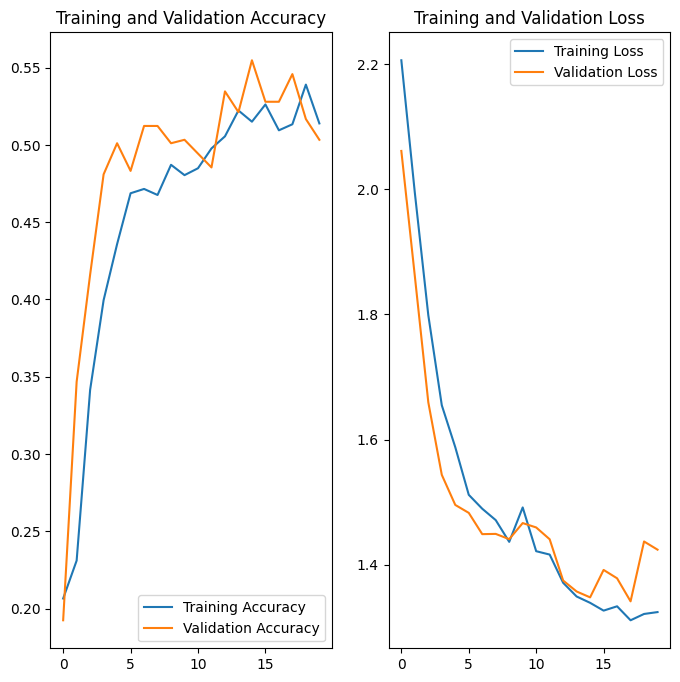

In [65]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model with dropout layers does seem to show better performance compared to the previous model without dropout. Although both models experienced fluctuations in accuracy and loss, adding dropout helped to stabilize the results and avoid a sharp overfitting trend seen in models with no regularization.

The validation accuracy is higher and more stable with the addition of dropout, though it still fluctuates. This indicates that dropout is having a positive effect on regularization but more fine-tuning may be needed for further improvement.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

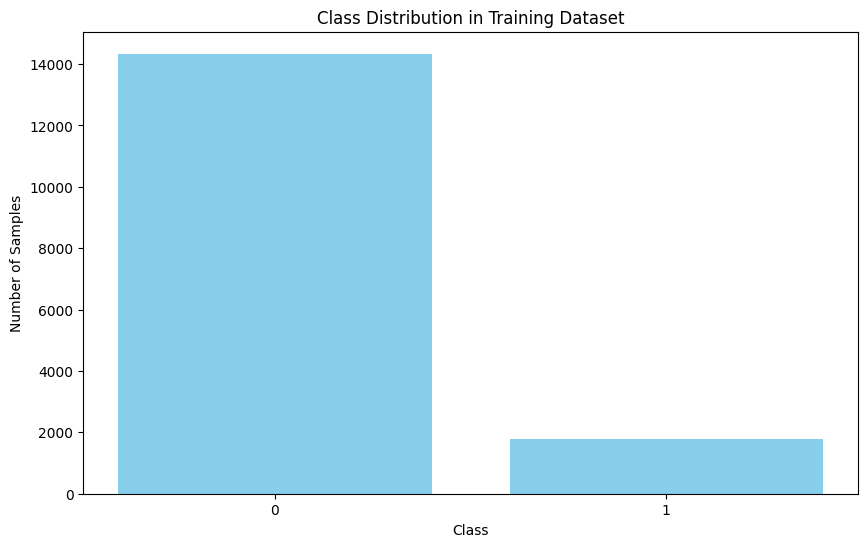

Class Distribution: {0.0: 14336, 1.0: 1792}


In [73]:
# Assuming you have the train_dataset with labels available
class_labels = []

# Iterate through the training dataset and collect labels
for images, labels in train_ds:
    class_labels.extend(labels.numpy())

# Convert to numpy array and count the occurrences of each class
class_labels = np.array(class_labels)
unique, counts = np.unique(class_labels, return_counts=True)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(unique)
plt.show()

# Optionally, print the class distribution
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

#### - Class 1 has the least amount of samples
#### - Class 0 dominates the amount of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [74]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [77]:
path_to_training_dataset=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1A86697110>: 100%|██████████| 500/500 [00:18<00:00, 27.28 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1A49722250>: 100%|██████████| 500/500 [00:18<00:00, 27.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E1A7BD03690>: 100%|██████████| 500/500 [00:20<00:00, 24.98 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E1A481F5690>: 100%|██████████| 500/500 [01:13<00:00,  6.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7E1A4972D450>: 100%|██████████| 500/500 [01:14<00:00,  6.75 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1A48145890>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E1A484E64D0>: 100%|██████████| 500/500 [00:40<00:00, 12.49 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E1A485EF110>: 100%|██████████| 500/500 [00:19<00:00, 25.32 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E1A497CF690>: 100%|██████████| 500/500 [00:18<00:00, 26.53 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [78]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [87]:
import glob  # Import the glob module
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))] # Use glob.glob to call the function from the module
path_list_new

['/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_8f0474e2-ecc5-4e43-9793-136f73646c2a.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_2be93049-6a8b-4af2-8446-3751e0e37937.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026984.jpg_c8dde5b1-992a-4f33-8307-49945d47a785.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_ab1639f7-5c01-447d-b07c-f269d6406624.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ac

In [88]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [89]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_new

In [1]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = train_ds.append(df2)

NameError: name 'pd' is not defined

In [94]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
dermatofibroma                500
seborrheic keratosis          500
squamous cell carcinoma       500
melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
vascular lesion               500
nevus                         500
Name: count, dtype: int64

KeyError: "['Label'] not in index"

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

